# Линейная регрессия и стохастический градиентный спуск

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import sys; sys.path.append('../..'); from lib import *

Задание основано на материалах лекций по линейной регрессии и градиентному спуску. Вы будете прогнозировать выручку компании в зависимости от уровня ее инвестиций в рекламу по TV, в газетах и по радио.

## Вы научитесь:
- решать задачу восстановления линейной регрессии
- реализовывать стохастический градиентный спуск для ее настройки
- решать задачу линейной регрессии аналитически

## Введение
Линейная регрессия - один из наиболее хорошо изученных методов машинного обучения, позволяющий прогнозировать значения количественного признака в виде линейной комбинации прочих признаков с параметрами - весами модели. Оптимальные (в смысле минимальности некоторого функционала ошибки) параметры линейной регрессии можно найти аналитически с помощью нормального уравнения или численно с помощью методов оптимизации.  

Линейная регрессия использует простой функционал качества - среднеквадратичную ошибку. Мы будем работать с выборкой, содержащей 3 признака. Для настройки параметров (весов) модели решается следующая задача:
$$\frac{1}{\ell}\sum_{i=1}^\ell{{(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}^2} \rightarrow \min_{w_0, w_1, w_2, w_3},$$
где $x_{i1}, x_{i2}, x_{i3}$ - значения признаков $i$-го объекта, $y_i$ - значение целевого признака $i$-го объекта, $\ell$ - число объектов в обучающей выборке.

## Градиентный спуск
Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$w_0 \leftarrow w_0 + \frac{2\eta}{\ell} \sum_{i=1}^\ell{{(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}}$$
$$w_j \leftarrow w_j + \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Инструкции по выполнению

В начале напишем простую функцию для записи ответов в текстовый файл. Ответами будут числа, полученные в ходе решения этого задания, округленные до 3 знаков после запятой. Полученные файлы после выполнения задания надо отправить в форму на странице задания на Coursera.org.

In [2]:
def write_answer_to_file(answer, filename):
    with open(filename, 'w') as f_out:
        f_out.write(str(round(answer, 3)))

**1. Загрузите данные из файла *advertising.csv* в объект pandas DataFrame. [Источник данных](http://www-bcf.usc.edu/~gareth/ISL/data.html).**

In [3]:
import pandas as pd
adver_data = pd.read_csv('advertising.csv')

**Посмотрите на первые 5 записей и на статистику признаков в этом наборе данных.**

In [4]:
data = adver_data
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [5]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


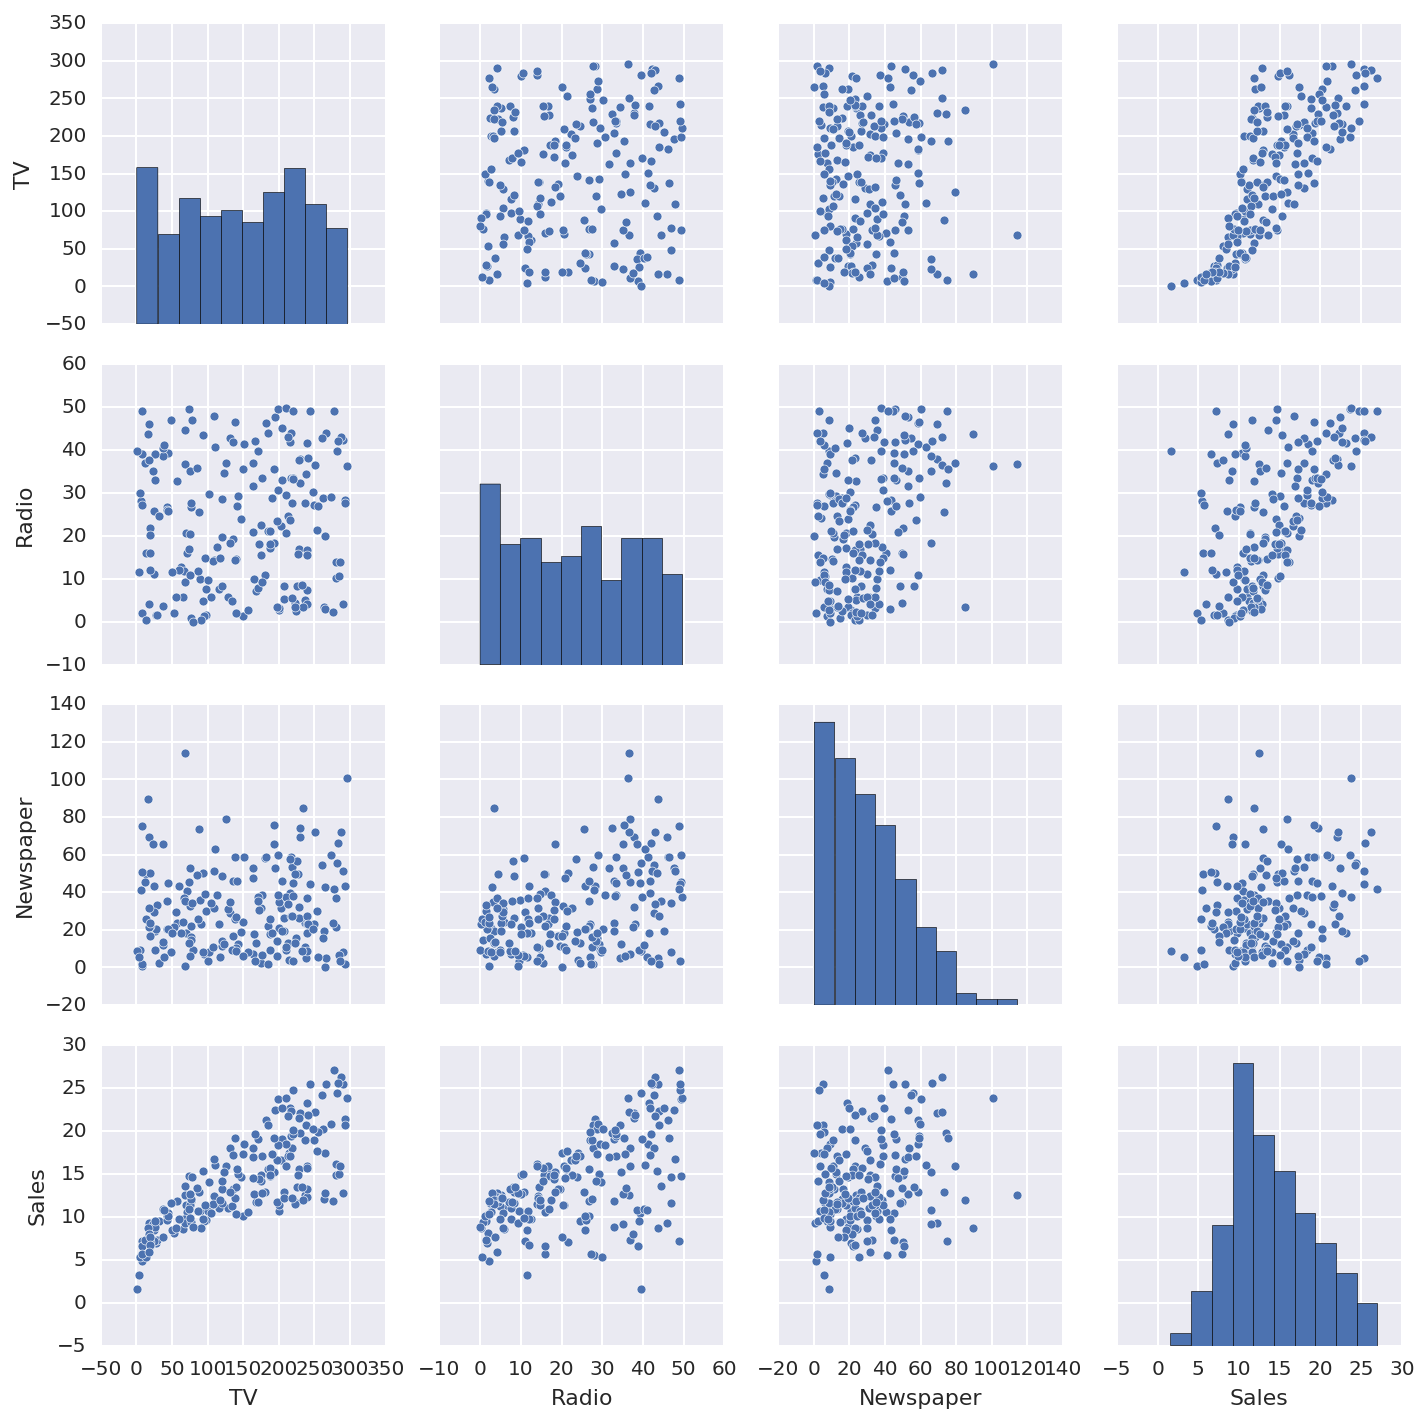

In [6]:
sns.pairplot(data)

**Создайте массивы NumPy *X* из столбцов TV, Radio и Newspaper и *y* - из столбца Sales. Используйте атрибут *values* объекта pandas DataFrame.**

In [7]:
X = data[['TV', 'Radio', 'Newspaper']].values
y = data['Sales'].values

**Отмасштабируйте столбцы матрицы *X*, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [8]:
means, stds = np.mean(X, axis=0), np.std(X, axis=0)

In [168]:
means, stds

(array([ 147.0425,   23.264 ,   30.554 ]),
 array([ 85.63933176,  14.80964564,  21.72410606]))

In [9]:
X = ((X - means) / stds)

**Добавьте к матрице *X* столбец из единиц, используя методы *hstack*, *ones* и *reshape* библиотеки NumPy. Вектор из единиц нужен для того, чтобы не обрабатывать отдельно коэффициент $w_0$ линейной регрессии.**

In [10]:
X = np.hstack((np.ones(len(y)).reshape(len(y),1), X))

**2. Реализуйте функцию *mserror* - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series *y* (значения целевого признака) и *y\_pred* (предсказанные значения).**

In [175]:
def mserror(y, y_pred):
    return sum(((y - y_pred) ** 2))/len(y)

**Какова среднеквадратичная ошибка прогноза значений Sales, если всегда предсказывать медианное значение Sales по исходной выборке? Запишите ответ в файл '1.txt'.**

In [176]:
answer1 = mserror(y, np.median(y))
print(answer1)
write_answer_to_file(answer1, '1.txt')

28.34575


## Нормальное уравнение 
Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, соответствующий целевому признаку, получался умножением матрицы $X$ (состоящей из всех признаков объектов обучающей выборки, кроме целевого) на вектор весов $w$. То есть, чтобы выполнялось матричное уравнение:
$$y = Xw$$
Домножением слева на $X^T$ получаем:
$$X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ - квадратная, и можно найти решение (вектор $w$) в виде:
$$w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [*псевдообратная*](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$. В NumPy такую матрицу можно вычислить с помощью функции [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

Однако, нахождение псевдообратной матрицы - операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). 
На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$X^TXw = X^Ty$$Это может быть сделано с помощью функции [numpy.linalg.solve](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html).

Но все же на практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

**3. Реализуйте функцию *normal_equation*, которая по заданным матрицам (массивам NumPy) *X* и *y* вычисляет вектор весов $w$ согласно нормальному уравнению линейной регрессии.**

In [177]:
def normal_equation(X, y):
    return np.dot(np.linalg.pinv(X), y)

In [178]:
norm_eq_weights = normal_equation(X, y)
print(norm_eq_weights)

[ 14.0225       3.91925365   2.79206274  -0.02253861]


**Какие продажи предсказываются линейной моделью с весами, найденными с помощью нормального уравнения, в случае средних инвестиций в рекламу по ТВ, радио и в газетах? (то есть при нулевых значениях масштабированных признаков TV, Radio и Newspaper). Запишите ответ в файл '2.txt'.**

In [179]:
# zip(np.zeros(4), norm_eq_weights)
answer2 = norm_eq_weights[0] 
print(answer2)
write_answer_to_file(answer2, '2.txt')

14.0225


**4. Напишите функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.**

In [180]:
def linear_prediction(X, w):
    return (X * w).sum(axis=1)
# linear_prediction(X, norm_eq_weights).shape

**Какова среднеквадратичная ошибка прогноза значений Sales в виде линейной модели с весами, найденными с помощью нормального уравнения? Запишите ответ в файл '3.txt'.**

In [181]:
answer3 = mserror(y, linear_prediction(X, norm_eq_weights))
print(answer3)
write_answer_to_file(answer3, '3.txt')

2.78412631451


## Стохастический градиентный спуск
У градиентного спуска, описанного выше, есть один недостаток. На больших выборках вычисление градиента по всем имеющимся данным на каждом шаге может быть вычислительно сложно. 
В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$w_0 \leftarrow w_0 + \frac{2\eta}{\ell} {(y_k - (w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}))}$$
$$w_j \leftarrow w_j + \frac{2\eta}{\ell} {x_{kj}(y_k - (w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}))},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

**5. Напишите функцию *stochastic_gradient_step*, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция должна принимать матрицу *X*, вектора *y* и *w*, число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов, а также число *$\eta$* (eta) - шаг градиентного спуска (по умолчанию *eta*=0.01). Результатом будет вектор обновленных весов.**

In [190]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    w1 = [0,0,0,0]
    k = train_ind
    l = len(y)
    a = lambda: 2*eta/l*(y[k]-sum(X[k]*w))
    w1[0] = w[0] + a() 
    for j in [1,2,3]:
        w1[j] = w[j] + X[k,j] * a()
    return w1
print(norm_eq_weights)
print(stochastic_gradient_step(X, y, norm_eq_weights, 0, eta=0.01))
print(X[0])

[ 14.0225       3.91925365   2.79206274  -0.02253861]
[14.022657602559029, 3.9194065060858629, 2.7922174336273677, -0.022258242530730336]
[ 1.          0.96985227  0.98152247  1.77894547]


**6. Напишите функцию *stochastic_gradient_descent*, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

In [197]:
from scipy.spatial.distance import euclidean

def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e5,
                                min_weight_dist=1e-8, seed=42, verbose=True):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        w1 = stochastic_gradient_step(X, y, w, random_ind, eta=eta)
        weight_dist = euclidean(w, w1)
#         weight_dist = np.linalg.norm(np.array(w1) - np.array(w))
        w = w1
        err = mserror(y, linear_prediction(X, w))
        errors.append(err)
        iter_num += 1
        if verbose and not iter_num % 1000: 
            print(iter_num, weight_dist, err)
            
    return w, errors

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов *w_init*, состоящий из нулей. Оставьте параметры  *eta* и *seed* равными их значениям по умолчанию (*eta*=0.01, *seed*=42 - это важно для проверки ответов).**

In [198]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, [0.,0.,0.,0.])

(1000, 0.0016785873945831006, 183.24755385232987)
(2000, 0.0024317907219769115, 149.99675458151748)
(3000, 0.0018035865894240727, 123.7169264511779)
(4000, 0.0012237452168144154, 102.52343199717787)
(5000, 0.0015694771647542058, 83.95082976172958)
(6000, 0.0009482337221676145, 69.137670525414748)
(7000, 0.0010987505373551282, 57.350953203785409)
(8000, 0.0009920117354591496, 47.463834705218325)
(9000, 0.0013970502286480527, 39.206944310778226)
(10000, 0.0015775944514537055, 32.776694648264119)
(11000, 0.0016781267044047707, 27.047952328342781)
(12000, 0.000816778474047181, 22.8997969627152)
(13000, 0.0005812575852444704, 19.225393720302719)
(14000, 0.00042898770232501865, 16.303032511464231)
(15000, 0.00037967914902947367, 13.771895380504862)
(16000, 0.0005417622451658419, 11.860624462281134)
(17000, 0.0005440674298503894, 10.232170351163914)
(18000, 0.00027021726340943863, 8.921797884426244)
(19000, 0.00046870234718315444, 7.8165672115382803)
(20000, 0.0013673647988632115, 6.961864017

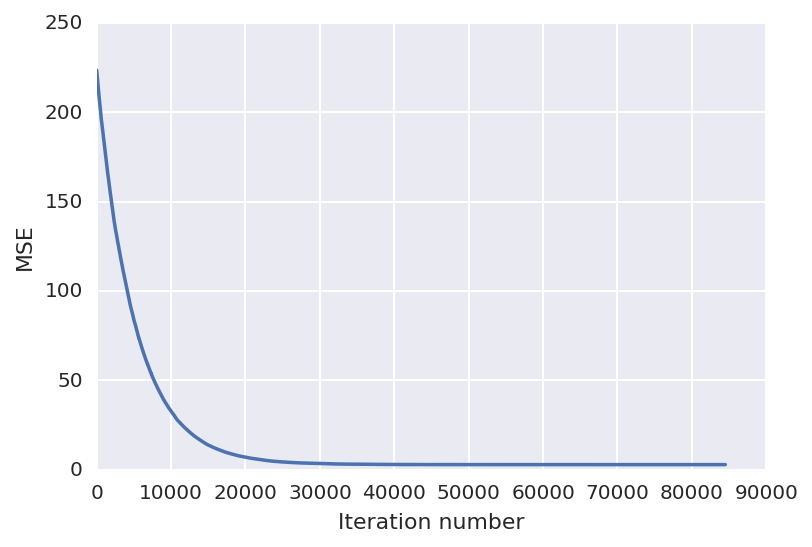

In [199]:
# %pylab inline
plt.plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

**Посмотрим на вектор весов, к которому сошелся метод.**

In [200]:
stoch_grad_desc_weights

[14.019056586442181,
 3.9106925568695687,
 2.7820980774019373,
 -0.0081046221682420441]

**Посмотрим на среднеквадратичную ошибку на последней итерации.**

In [201]:
stoch_errors_by_iter[-1]

2.7844125884067039

**Какова среднеквадратичная ошибка прогноза значений Sales в виде линейной модели с весами, найденными с помощью градиентного спуска? Запишите ответ в файл '4.txt'.**

In [202]:
answer4 = mserror(y, linear_prediction(X, stoch_grad_desc_weights))
print(answer4)
write_answer_to_file(answer4, '4.txt')

2.78441258841


**Ответами к заданию будут текстовые файлы, полученные в ходе этого решения. Обратите внимание, что отправленные файлы не должны содержать пустую строку в конце. Данный нюанс является ограничением платформы Coursera. Мы работаем над исправлением этого ограничения.**